### T12s are financial documents of Real Estate properties. We will build a simple RAG Application first and then experiment with fine-tuning an embedding model for Q&A task.

In [ ]:
%load_ext cudf.pandas

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:61: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


ImportError: 
================================================================
Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcuda.so.1: cannot open shared object file: No such file or directory
================================================================


In [ ]:
import sys
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from PIL import Image
import requests

In [ ]:
%cd /content/drive/My Drive/LLMs/Q&A

/content/drive/My Drive/LLMs/Q&A


In [ ]:
url = "https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/RAG_workflow.png"

img = Image.open(requests.get(url, stream=True).raw)
# Resize the image
resized_img = img.resize((700, 700))

# Optionally save the resized image
resized_img.save('resized_image.png', 'PNG')

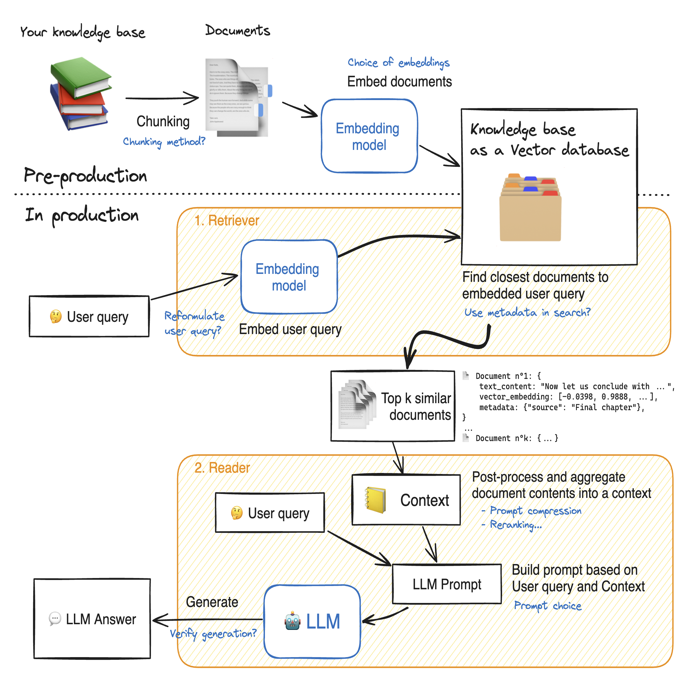

In [ ]:
# Optionally display the resized image inline (requires additional libraries)
from IPython.display import display
display(resized_img)

In [ ]:
!python --version

Python 3.10.12


In [ ]:
files = !ls
files = list(files)
#files = [item for item in files[0].strip().split()]
files

[" Chroma      data\t        resized_image.png\t\t   't12_q&a.ipynb'",
 ' chroma_db   requirements.txt   stroom-vertexai-37730f77939e.json']

In [ ]:
#!pip freeze > requirements.txt
if 'requirements.txt' in files:
  !pip install -r requirements.txt
!pip install -r requirements.txt

  Cloning https://github.com/FlagOpen/FlagEmbedding.git to /tmp/pip-req-build-yzkcgx2u
  Running command git clone --filter=blob:none --quiet https://github.com/FlagOpen/FlagEmbedding.git /tmp/pip-req-build-yzkcgx2u
  Resolved https://github.com/FlagOpen/FlagEmbedding.git to commit 80201e271ff30a697bfcd9d97f53c0b228e83d52
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-8uzff634
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-8uzff634
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.5/559.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.6/974.6 kB 5

In [ ]:
import torch
import os
import pandas as pd
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex, Document, Settings, StorageContext
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_parse import LlamaParse
#from openpyxl import load_workbook
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
#import FlagEmbedding

# https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2 | Maps text to a 384 dimensional dense vector space.
Settings.embed_model = HuggingFaceEmbedding(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

import chromadb
import wandb
from transformers import pipeline

from langchain.chains.question_answering import load_qa_chain
from langchain.chains import RetrievalQA
from langchain.vectorstores import Chroma
#from langchain_community.embeddings.sentence_transformer import (SentenceTransformerEmbeddings)
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import TokenTextSplitter, CharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader

"""
sentence-transformers model: It maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search.
"""
embedding_function = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

import instructor
#from openai import OpenAI
from typing import Optional
from pydantic import BaseModel
from pydantic import Field
from mistralai.client import MistralClient
from instructor.function_calls import Mode
from llama_index.llms.mistralai import MistralAI
from llama_index.llms.openai import OpenAI as OpenAI_llama
from openai import OpenAI
import nest_asyncio
nest_asyncio.apply()
import base64

from google.colab import userdata

# vertexAI
from google.oauth2 import service_account
from google.cloud import aiplatform
from vertexai.preview import rag
from vertexai.preview.generative_models import GenerativeModel, Tool
import vertexai

# Project
project_id = "stroom-vertexai"
display_name = "text_corpus"
paths = [os.getcwd() + "/data"]  # Supports Google Cloud Storage and Google Drive Links


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(sentences)
print(f"Length: {len(embeddings)}, Embeddings dimensions: {embeddings[0].shape}")

Length: 1, Embeddings dimensions: (384,)


In [ ]:
embeddings[0][0:10]

array([ 0.06765693,  0.0634959 ,  0.04871312,  0.07930496,  0.03744806,
        0.00265279,  0.03937496, -0.00709846,  0.05936139,  0.031537  ],
      dtype=float32)

In [ ]:
# # create client and a new collection
# collection_name = "my_news"

# # If you have created the collection before, you need to delete the collection first
# if len(chroma_client.list_collections()) > 0 and collection_name in [chroma_client.list_collections()[0].name]:
#     chroma_client.delete_collection(name=collection_name)

# print(f"Creating collection: '{collection_name}'")
# collection = chroma_client.create_collection(name=collection_name)

# db = chromadb.PersistentClient(path="./chroma_db")
# chroma_collection = db.create_collection("t12_financials")

In [ ]:
f"GPU count: {torch.cuda.device_count()}"

'GPU count: 1'

In [ ]:
gpu_names = [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]
print("GPU(s) available: {}".format(gpu_names))

GPU(s) available: ['Tesla T4']


In [ ]:
dir_path = "/content/drive/My Drive/LLMs/Q&A/data/pdfs/"

for file in os.listdir(dir_path):
  print(file)

The_Orion_Alex.pdf
cash_flow_12_month-20231115[AppFolio].pdf
12_Month_Statement_rfcorela_Accrual.pdf
12_Month_Statement_p2140_Accrual.pdf
12_Month_Statement_logan_Accrual.pdf
12_Month_Statement_konrad_Accrual.pdf
12_Month_Statement_harland_Accrual.pdf
0Standard_ProfitandLoss_Trailing12Months.pdf
12_Month_Statement_rfcascaa_Accrual.pdf


Llamaindex seems to work better with parsing PDFs. So, let's convert .xlsx to .pdfs.

In [ ]:
# def xlsx_to_pdf(input_file, output_file):
#     # Load the Excel file
#     wb = load_workbook(input_file)
#     ws = wb.active

#     # Create a PDF
#     c = canvas.Canvas(output_file, pagesize=letter)
#     y = 800  # Initial y-coordinate for writing text

#     for row in ws.iter_rows():
#         x = 50  # Initial x-coordinate for writing text
#         for cell in row:
#             c.drawString(x, y, str(cell.value))
#             x += 100  # Adjust this value according to your needs
#         y -= 20  # Adjust this value according to your needs

#     c.save()

In [ ]:
# def convert_excel_to_pdf(dir_path):

#   for file in os.listdir(dir_path):
#     if file.endswith('.xlsx'):
#       input_file = os.path.join(dir_path, file)
#       output_file = os.path.splitext(input_file)[0] + '.pdf'

#       xlsx_to_pdf(input_file, output_file)
#       print(f"Converted {file} to PDF.")

In [ ]:
#convert_excel_to_pdf(dir_path)

#### Let's start with a simple RAG architecture

In [ ]:
def load_chunk_persist_pdf() -> Chroma:
    pdf_folder_path = "/content/drive/My Drive/LLMs/Q&A/data/pdfs/"
    documents = []
    # Load each .pdf doc in a document list
    for file in os.listdir(pdf_folder_path):
        if file.endswith('.pdf'):
            pdf_path = os.path.join(pdf_folder_path, file)
            loader = PyPDFLoader(pdf_path)
            documents.extend(loader.load())

    # chunk
    #text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=10)
    #chunked_documents = text_splitter.split_documents(documents)

    # Naively chunk the SEC filing by tokens
    token_splitter = TokenTextSplitter(chunk_size=1000, chunk_overlap=100)
    docs = token_splitter.split_documents(documents)

    # Create a vector store / DB
    client = chromadb.Client()
    collection_name = "t12_financials"

    if len(client.list_collections()) > 0 and collection_name in [client.list_collections()[0].name]:
      client.delete_collection(name=collection_name)
    else:
        print(f"Creating collection: '{collection_name}'")
        collection = client.create_collection(name=collection_name)

    # Create a vectorDB
    vectordb = Chroma.from_documents(
        documents=docs,
        embedding=embedding_function,
        persist_directory="/content/drive/My Drive/LLMs/Q&A/Chroma"
    )

    vectordb.persist()

    return vectordb

In [ ]:
vdb = load_chunk_persist_pdf()

In [ ]:
# load from disk
vdb = Chroma(persist_directory="./Chroma", embedding_function=embedding_function)
vdb

#### Retrive the Context for the Query

In [ ]:
query = "What was the Gross Potential Rent in May 2023 at Cascade Link Douglas?"

# Get documents from vectorDB
k = 5
top_k_docs = vdb.similarity_search(query, k)

context = "\n".join([doc.page_content for doc in top_k_docs])
f"Length: {len(context)} Context: {context}"

NameError: name 'vdb' is not defined

#### Answer and structure output with Instructor

https://pypi.org/project/instructor/

In [ ]:
# Define our data model
class Financials(BaseModel):
      Property: Optional[str] = Field(description="Property Name", default=None)
      period: Optional[str] = Field(description="The financial period like Oct 2023", default=None)
      Item: Optional[str] = Field(description="Line-item on the T12 Financial statement", default=None)
      Header: Optional[str] = Field(description="Category", default=None)
      Sub_Header: Optional[str] = Field(description="Sub-Category", default=None)
      dollar_value: Optional[str] = Field(description="currency", default=None)


Now, let's instantiate instructor and enable `response_model` in chat call.

First, let's check the pricing from different model providers. For the specific models, we are using `gpt-3.5-turbo` and `mistral-small`, here's the pricing.

*   https://openai.com/api/pricing/   $0.50/1m tokens

*   https://mistral.ai/technology/    $1/1m tokens



In [ ]:
# OPENAI
oclient = OpenAI(
    api_key = userdata.get('OPENAI_API_KEY')
)

for m in oclient.models.list():
  print(m)

In [ ]:
# Extract structured data from natural language
oclient = instructor.from_openai(OpenAI(api_key=userdata.get('OPENAI_API_KEY')))

resp = oclient.chat.completions.create(
    model="gpt-3.5-turbo-0125",
    response_model=Financials,
     messages=[
        {"role": "system", "content": "You are an expert financial assistant that reads Real Estate Property P&L documents and answers questions."},
        {"role": "user", "content": f"Question: {query} Context: {context}"},
    ],
)

print(resp)

Property='Tillicum Apartments' period='Mar 2023' Item='Section 8 Rent' Header='Income' Sub_Header='RENTS' dollar_value=None


In [ ]:
# MISTRAL
mclient = MistralClient(api_key=userdata.get('MISTRAL_API_KEY'))
patched_chat = instructor.patch(create=mclient.chat, mode=Mode.MISTRAL_TOOLS)

resp = patched_chat(
    model="mistral-small-latest",
    response_model=Financials,
    messages=[
        {"role": "system", "content": "You are an expert financial assistant that reads Real Estate Property P&L documents and answers questions."},
        {"role": "user", "content": f"Question: {query} Context: {context}"},
    ],
)

print(resp)

Property='The Tillicum Apartments' period='March 2023' Item='Section 8 Rent' Header=None Sub_Header=None dollar_value=None


**Findings/Learnings/Observations:**

The response from both `OpenAI` and `Mistral` LLMs is not quite what we are looking for. It seems to not realize the exact positioning / row and column table format. Let's try a few different approaches that builds on this naive-RAG.

A few of promising approaches to try:

- https://blog.langchain.dev/semi-structured-multi-modal-rag/
- https://www.llamaindex.ai/blog/introducing-llamacloud-and-llamaparse-af8cedf9006b
- https://github.com/run-llama/llama_parse/blob/main/examples/demo_advanced.ipynb
- https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_Structured_RAG.ipynb
- https://docs.llamaindex.ai/en/stable/examples/agent/structured_planner/
- https://www.linkedin.com/posts/llamaindex_performing-complex-financial-calculations-activity-7191091747765080065-usIh/
- https://www.linkedin.com/posts/hanane-d-algo-trader_anthropic-agent-rag-with-complex-financial-activity-7190389324343881728-TOXX/
- https://medium.com/the-ai-forum/multi-document-agentic-rag-using-llama-index-and-mistral-b334fa45d3ee

### **Promising approach #1**

`llamaparse` + `recursive-query-engine` + `re-ranker`

Let's try `Llama-parse` as the pdf parsing looks promising.

We also compare two different retrieval/query engine strategies:

1. Using raw Markdown text as nodes for building index and apply simple query engine for generating the results
2. Using `MarkdownElementNodeParser` for parsing the `LlamaParse output Markdown` results and building `recursive retriever query engine` for generation

Before we dive-in, `Document` and `Node` objects are core abstractions within LlamaIndex.

A `Document` is a generic container around any data source - for instance, a PDF, an API output, or retrieved data from a database. They can be constructed manually, or created automatically via our data loaders. By default, a Document stores text along with some other attributes.

A `Node` represents a "chunk" of a source Document, whether that is a text chunk, an image, or other. Similar to Documents, they contain metadata and relationship information with other nodes.

`Nodes` are a first-class citizen in LlamaIndex. You can choose to define Nodes and all its attributes directly. You may also choose to "parse" source Documents into Nodes through our `NodeParser` classes.


The concept of `recursive retrieval` is that we not only explore the directly most relevant nodes, but also explore node relationships to additional retrievers/query engines and execute them. For instance, a node may represent a concise summary of a structured table, and link to a SQL/Pandas query engine over that structured table. Then if the node is retrieved, we want to also query the underlying query engine for the answer.

This can be especially useful for documents with hierarchical relationships. In this example, we walk through a Wikipedia article about billionaires (in PDF form), which contains both text and a variety of embedded structured tables. We first create a Pandas query engine over each table, but also represent each table by an IndexNode (stores a link to the query engine); this Node is stored along with other Nodes in a vector store.

During query-time, if an IndexNode is fetched, then the underlying query engine/retriever will be queried.



Pre-reading:

*   https://docs.llamaindex.ai/en/stable/module_guides/loading/documents_and_nodes/
*   https://docs.llamaindex.ai/en/stable/module_guides/loading/node_parsers/
*   https://docs.llamaindex.ai/en/v0.10.19/api/llama_index.core.node_parser.MarkdownElementNodeParser.html
*   https://docs.llamaindex.ai/en/stable/examples/node_postprocessor/FlagEmbeddingReranker/



In [ ]:
parser = LlamaParse(
    api_key=userdata.get('LLAMA_CLOUD_API_KEY'),
    result_type="markdown",
    num_workers=4,
    verbose=True
)

pdf_folder_path = "/content/drive/My Drive/LLMs/Q&A/data/"
parser_docs = []

# Load each .pdf doc in a document list
for file in os.listdir(pdf_folder_path):
    if file.endswith('.pdf'):
      parser_docs.append("{}".format(pdf_folder_path + "/" + file))

parsed_docs = parser.load_data(parser_docs)

Parsing files: 0it [00:00, ?it/s]


In [ ]:
parsed_docs[0].text[:1000]

"|Income|Mar 2022|Apr 2022|May 2022|Jun 2022|Jul 2022|Aug 2022|Sep 2022|Oct 2022|Nov 2022|Dec 2022|Jan 2023|Feb 2023|\n|---|---|---|---|---|---|---|---|---|---|---|---|---|\n|Rental Income| | | | | | | | | | | | |\n|Market Rent Residential|277,725|297,310|285,120|286,140|290,050|290,500|291,325|295,605|294,200|295,852|297,205|297,950|\n|Loss To Lease Residentia|(19,272)|(35,454)|(20,303)|(15,555)|(13,152)|(11,623)|(9,465)|(10,690)|(20,879)|23,150|(5,136)|(8,518)|\n|Gross Potential Rent|258,453|261,856|264,817|270,585|276,898|278,877|281,860|284,915|273,321|319,002|292,069|289,432|\n|Income Adjustments| | | | | | | | | | | | |\n|Vacancy Residential|(9,360)|(15,183)|(15,065)|(21,983)|(21,585)|(20,636)|(15,315)|(15,582)|(20,897)|(21,508)|(23,573)|(20,893)|\n|Collection Company Fee|0|0|0|(209)|0|0|0|0|0|0|0|0|\n|Cash Rec'D Collection Co|0|0|679|500|0|0|0|0|0|0|0|0|\n|Rent Adjustment - Move Out|(6,698)|(4,491)|465|(465)|(670)|(9,827)|0|(3,444)|3,152|(1,028)|(9,857)|(774)|\n|Non Revenue Unit

In [ ]:
"""
Markdown element node parser.

Splits a markdown document into Text Nodes and Index Nodes corresponding to embedded objects (e.g. tables).
"""

from llama_index.core.node_parser import MarkdownElementNodeParser

node_parser = MarkdownElementNodeParser(
                                        llm=MistralAI(
                                                      model="mistral-small-latest",
                                                      api_key=userdata.get('MISTRAL_API_KEY')
                                                     )
                                       )

nodes = node_parser.get_nodes_from_documents(parsed_docs)

Streaming output truncated to the last 5000 lines.
      "col_name": "May",
      "col_type": "number",
      "summary": "Expenses for May"
    },
    {
      "col_name": "Jun",
      "col_type": "number",
      "summary": "Expenses for June"
    },
    {
      "col_name": "Jul",
      "col_type": "number",
      "summary": "Expenses for July"
    },
    {
      "col_name": "Aug",
      "col_type": "number",
      "summary": "Expenses for August"
    },
    {
      "col_name": "Sep",
      "col_type": "number",
      "summary": "Expenses for September"
    },
    {
      "col_name": "Oct",
      "col_type": "number",
      "summary": "Expenses for October"
    }; pos=1417; lineno=60; colno=6)
__root__
  Expecting ',' delimiter: line 60 column 6 (char 1421) (type=value_error.jsondecode; msg=Expecting ',' delimiter; doc={
  "summary": "This table presents the monthly breakdown and total of non-controllable expenses for the account range 7890-9999.",
  "table_title": "7890-9999 TOTAL NON-

In [ ]:
for n in enumerate(nodes[:5]):
  print(n)

(0, IndexNode(id_='6a6f0aa1-866c-438d-84e0-c23fb350dbeb', embedding=None, metadata={'col_schema': 'Column: Income Category\nType: string\nSummary: None\n\nColumn: Mar 2022\nType: number\nSummary: None\n\nColumn: Apr 2022\nType: number\nSummary: None\n\nColumn: May 2022\nType: number\nSummary: None\n\nColumn: Jun 2022\nType: number\nSummary: None\n\nColumn: Jul 2022\nType: number\nSummary: None\n\nColumn: Aug 2022\nType: number\nSummary: None\n\nColumn: Sep 2022\nType: number\nSummary: None\n\nColumn: Oct 2022\nType: number\nSummary: None\n\nColumn: Nov 2022\nType: number\nSummary: None\n\nColumn: Dec 2022\nType: number\nSummary: None\n\nColumn: Jan 2023\nType: number\nSummary: None\n\nColumn: Feb 2023\nType: number\nSummary: None'}, excluded_embed_metadata_keys=['col_schema'], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='25820f77-e0a0-4b3d-9fb6-07cc7f499f89', node_type=<ObjectType.DOCUMENT: '4'>, metadata={}, hash='3837e6229dd1a

In [ ]:
# split into base nodes and objects
base_nodes, objects = node_parser.get_nodes_and_objects(nodes)
print(f"Base nodes: {base_nodes}")
print(f"Objects: {objects}")

Base nodes: [TextNode(id_='408aacba-7d70-432d-ac8b-9875544b02cc', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='25820f77-e0a0-4b3d-9fb6-07cc7f499f89', node_type=<ObjectType.DOCUMENT: '4'>, metadata={}, hash='3837e6229dd1a25d9f320518a0bb92e4310bb6e621431c175ee049efa068f159'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='ef65d639-b8f1-40d7-9c6b-281d1714896f', node_type=<ObjectType.TEXT: '1'>, metadata={'table_df': '{\'Income\': {0: \'Rental Income\', 1: \'Market Rent Residential\', 2: \'Loss To Lease Residentia\', 3: \'Gross Potential Rent\', 4: \'Income Adjustments\', 5: \'Vacancy Residential\', 6: \'Collection Company Fee\', 7: "Cash Rec\'D Collection Co", 8: \'Rent Adjustment - Move Out\', 9: \'Non Revenue Units\', 10: \'Total Income Adjustments\', 11: \'Total Rental Income\', 12: \'Other Income\', 13: \'Other Charges\', 14: \'Rent Up-Charge\', 15: \'Lat

In [ ]:
#recursive_index = VectorStoreIndex(nodes=base_nodes + objects)
#raw_index = VectorStoreIndex.from_documents(parsed_docs)

In [ ]:
# set up ChromaVectorStore and load in data
vdb = chromadb.PersistentClient(path="./chroma_db")

In [ ]:
collection_name1 = "raw_index_fin"
collection_name2 = "recursive_index_fin"

collection_names = [collection_name1, collection_name2]

collections = vdb.list_collections()

collections_list = [c.name for c in collections]

for collection in collection_names:
  if collection in collections_list:
    vdb.delete_collection(name=collection)
    print(f"Collection '{collection}' deleted.")

Collection 'raw_index_fin' deleted.
Collection 'recursive_index_fin' deleted.


In [ ]:
# Create Raw Index and save to disk
chroma_raw_collection = vdb.create_collection(collection_name1)
print(f"Collection '{collection_name1}' created.")

vector_store = ChromaVectorStore(chroma_collection=chroma_raw_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

raw_index = VectorStoreIndex.from_documents(
                                               parsed_docs,
                                               storage_context = storage_context,
                                               embed_model = Settings.embed_model
                                           )

# Create Recursive Index
chroma_recursive_collection = vdb.create_collection(collection_name2)
print(f"Collection '{collection_name2}' created.")

vector_store = ChromaVectorStore(chroma_collection=chroma_recursive_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

recursive_index = VectorStoreIndex(
                                    nodes = base_nodes + objects,
                                    storage_context = storage_context,
                                    embed_model = Settings.embed_model
                                  )

Collection 'raw_index_fin' created.
Collection 'recursive_index_fin' created.


In [ ]:
# load from disk

# raw index
vector_store = ChromaVectorStore(chroma_collection=chroma_raw_collection)

raw_index = VectorStoreIndex.from_vector_store(
                                                vector_store,
                                                embed_model=Settings.embed_model,
                                              )

# recursive index
vector_store = ChromaVectorStore(chroma_collection=chroma_recursive_collection)

recursive_index = VectorStoreIndex.from_vector_store(
                                                     vector_store,
                                                     embed_model=Settings.embed_model,
                                                    )

#### Re-ranker

In two-stage systems, a first-stage model (an bi-encoder embedding model/retriever) retrieves a set of relevant documents from a larger dataset. Then, a second-stage model (the reranker) is used to rerank those documents retrieved by the first-stage model. We use two stages because retrieving a small set of documents from a large dataset is much faster than reranking a large set of documents.

Rerankers are much more accurate than embedding models.

The intuition behind a bi-encoder's inferior accuracy is that bi-encoders must compress all of the possible meanings of a document into a single vector — meaning we lose information. Additionally, bi-encoders have no context on the query because we don't know the query until we receive it (we create embeddings before user query time).

On the other hand, a reranker can receive the raw information directly into the large transformer computation, meaning less information loss. Because we are running the reranker at user query time, we have the added benefit of analyzing our document's meaning specific to the user query — rather than trying to produce a generic, averaged meaning.

How Rerank works? https://docs.cohere.com/docs/overview

https://cohere.com/blog/say-hello-to-precision-how-rerankers-and-embeddings-boost-search


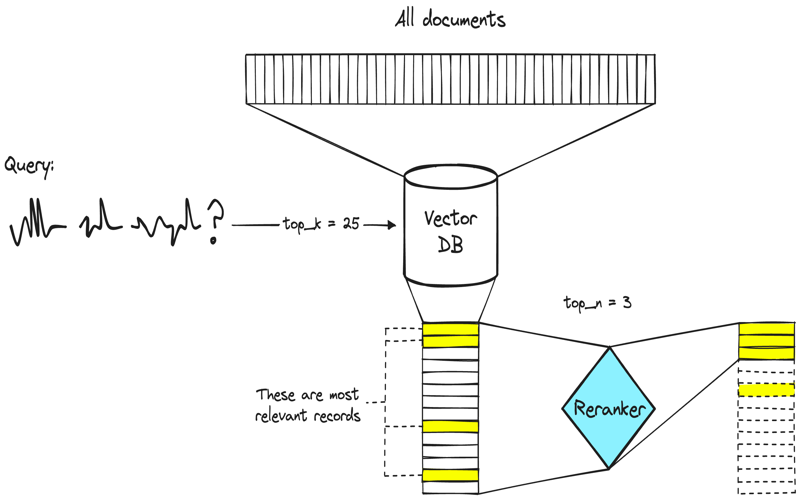

In [ ]:
url = "https://cdn.sanity.io/images/vr8gru94/production/906c3c0f8fe637840f134dbf966839ef89ac7242-3443x1641.png"

img = Image.open(requests.get(url, stream=True).raw)
# Resize the image
resized_img = img.resize((800, 500))

# Optionally save the resized image
resized_img.save('resized_image.png', 'PNG')

display(resized_img)

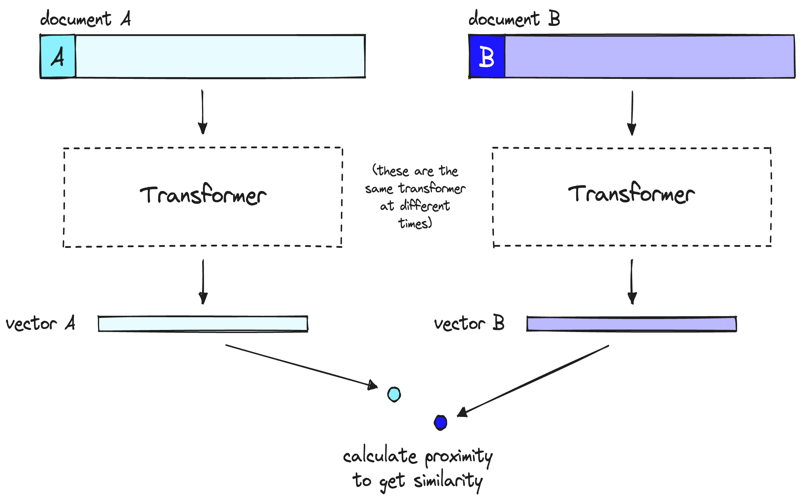

'\nWhen using bi-encoder models with vector search, we frontload all of the heavy transformer computation to when we are creating the initial vectors — that means that when a user queries our system, we have already created the vectors, so all we need to do is:\n> Run a single transformer computation to create the query vector. \n> Compare the query vector to document vectors with cosine similarity (or another lightweight metric). \n'

In [ ]:
url = "https://cdn.sanity.io/images/vr8gru94/production/4509817116ab72e27bae809c38cb48fbf1578b5d-2760x1420.png"

img = Image.open(requests.get(url, stream=True).raw)
# Resize the image
resized_img = img.resize((800, 500))

# Optionally save the resized image
resized_img.save('resized_image.png', 'PNG')

display(resized_img)

"""
When using bi-encoder models with vector search, we frontload all of the heavy transformer computation to when we are creating the initial vectors — that means that when a user queries our system, we have already created the vectors, so all we need to do is:
> Run a single transformer computation to create the query vector.
> Compare the query vector to document vectors with cosine similarity (or another lightweight metric).
"""

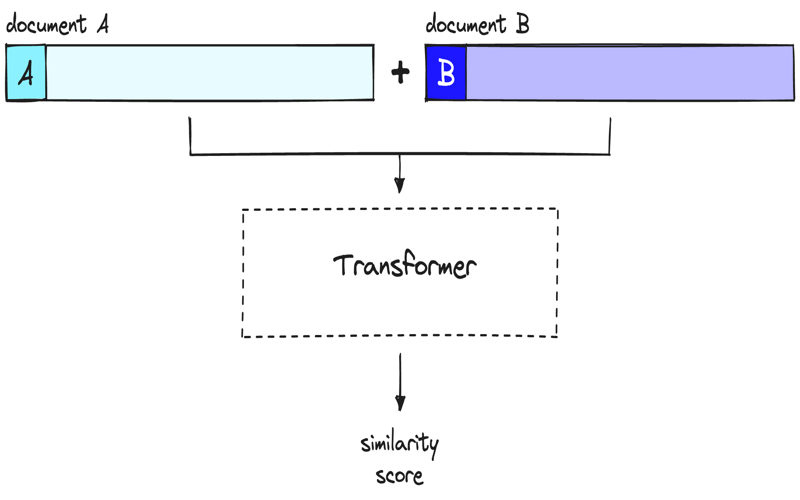

"\nWith rerankers, we are not pre-computing anything. Instead, we're feeding our query and a single other document into the transformer, running a whole transformer inference step, and outputting a single similarity score. Rerankers avoid the information loss of bi-encoders — but they come with a different penalty — time.\n"

In [ ]:
url = "https://cdn.sanity.io/images/vr8gru94/production/9f0d2f75571bb58eecf2520a23d300a5fc5b1e2c-2440x1100.png"

img = Image.open(requests.get(url, stream=True).raw)
# Resize the image
resized_img = img.resize((800, 500))

# Optionally save the resized image
resized_img.save('resized_image.png', 'PNG')

display(resized_img)

"""
With rerankers, we are not pre-computing anything. Instead, we're feeding our query and a single other document into the transformer, running a whole transformer inference step, and outputting a single similarity score. Rerankers avoid the information loss of bi-encoders — but they come with a different penalty — time.
"""

In [ ]:
from llama_index.postprocessor.flag_embedding_reranker import FlagEmbeddingReranker


# llm = MistralAI(
#                 model="mistral-small-latest",
#                 api_key=userdata.get('MISTRAL_API_KEY')
#                )

llm = OpenAI(
              model="gpt-3.5-turbo-0125",
              api_key=userdata.get('OPENAI_API_KEY')
            )


reranker = FlagEmbeddingReranker(
    top_n=10, # No. of nodes to return
    model="BAAI/bge-reranker-large",
    use_fp16=False
)

#### What is a recursive retriever?

A retriever will recursively explore links from nodes to other retrievers/query engines.

For any retrieved nodes, if any of the nodes are `IndexNodes`, then it will explore the linked retriever/query engine, and query that.

There are two motivating factors that lead to solutions for better retrieval:

* Decoupling retrieval embeddings from chunk-based synthesis. Oftentimes fetching documents by their summaries will return more relevant context to queries rather than raw chunks. This is something that recursive retrieval directly allows.

* Within a document, users may need to dynamically perform tasks beyond fact-based question-answering. We introduce the concept of "document agents" - agents that have access to both vector search and summary tools for a given document.

In [ ]:
raw_query_engine = raw_index.as_query_engine(
                                              similarity_top_k=15, # retrieve top_k similar nodes
                                              node_postprocessors=[reranker],
                                              llm=llm
                                            )

recursive_query_engine = recursive_index.as_query_engine(
                                                          similarity_top_k=15,
                                                          node_postprocessors=[reranker],
                                                          verbose=True,
                                                          llm=llm
                                                        )

In [ ]:
print(len(nodes))

414


In [ ]:
query

'What was the Gross Potential Rent in May 2023 at Cascade Link Douglas?'

In [ ]:
query = "What was the Net Operating Cash Flow in Jan 2023 at The Orion ?"

In [ ]:
response_1 = raw_query_engine.query(query)
print("\n***********New LlamaParse+ Basic Query Engine***********")
print(response_1)

response_2 = recursive_query_engine.query(query)
print("\n***********New LlamaParse+ Recursive Retriever Query Engine***********")
print(response_2)


***********New LlamaParse+ Basic Query Engine***********
What was the Net Operating Cash Flow in Jan 2023 at The Orion?
Answer: $185,689.11
Retrieval entering be942200-8890-446d-97e3-758ba9517dac: TextNode
Retrieving from object TextNode with query What was the Net Operating Cash Flow in Jan 2023 at The Orion ?
Retrieval entering 4c9a6a03-2ec9-4410-a75e-821ef425d37c: TextNode
Retrieving from object TextNode with query What was the Net Operating Cash Flow in Jan 2023 at The Orion ?
Retrieval entering 0f490283-aa35-4265-850e-34823823e9c4: TextNode
Retrieving from object TextNode with query What was the Net Operating Cash Flow in Jan 2023 at The Orion ?
Retrieval entering c6acd715-5a58-416e-ba79-4a6ca3a10b1d: TextNode
Retrieving from object TextNode with query What was the Net Operating Cash Flow in Jan 2023 at The Orion ?
Retrieval entering 1a92875e-5480-4a2f-9ff1-57ee4d81705e: TextNode
Retrieving from object TextNode with query What was the Net Operating Cash Flow in Jan 2023 at The Or

**Findings/Learnings/Observations:**

We experimented with `mistral` and `OpenAI` models. `OpenAI` model seems to do a better job a retrieval, esp. with `re-ranker` + `recursive` retriever query engine. Although, we do not quite have the accuracy of the responses we are looking for.

### **Promising approach #2**

Now, let's try using combination of recursive querying + Document Agents.

* https://github.com/ysymyth/ReAct
* https://www.youtube.com/watch?v=pRUc6JPw6CY
* https://docs.llamaindex.ai/en/stable/module_guides/deploying/agents/
* https://docs.llamaindex.ai/en/stable/examples/query_engine/recursive_retriever_agents/
* https://lilianweng.github.io/posts/2023-06-23-agent/

Data Agents are LLM-powered knowledge workers in LlamaIndex that can intelligently perform various tasks over your data, in both a “read” and “write” function. They are capable of the following:

Perform automated search and retrieval over different types of data - unstructured, semi-structured, and structured.
Calling any external service API in a structured fashion, and processing the response + storing it for later.
In that sense, agents are a step beyond our query engines in that they can not only "read" from a static source of data, but can dynamically ingest and modify data from a variety of different tools.

Building a data agent requires the following core components:

- A reasoning loop
- Tool abstractions

A data agent is initialized with set of APIs, or Tools, to interact with; these APIs can be called by the agent to return information or modify state. Given an input task, the data agent uses a reasoning loop to decide which tools to use, in which sequence, and the parameters to call each tool.

In our document Q&A, we can leverage agents to answer questions like, `find all income related items from the financial statement and sum them up for the period Jan 2021`?


Building `Document Agents`:

In this section we define "document agents" for each document.

First we define both a vector index (for semantic search) and summary index (for summarization) for each document. The two query engines are then converted into tools that are passed to an OpenAI function calling agent.

This document agent can dynamically choose to perform semantic search or summarization within a given document.

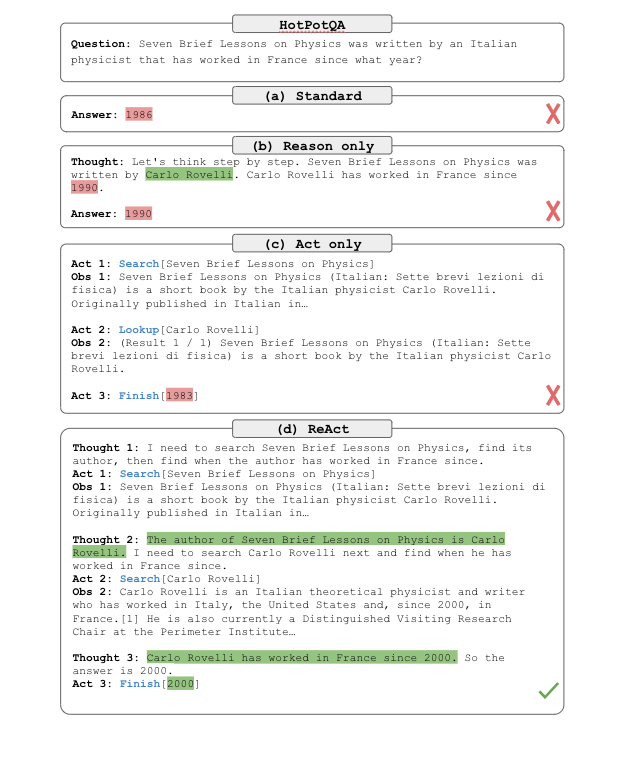

In [ ]:
url = "https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEhoAazr9qsoobs5Nkp7_uxjml4AEWA9iwUfoNfJpcJEnj2ZOdrTXptaf9R2CyRK7Qif64zcPbywR6AeIOaeZs19vQ7OH6n-6vEyh1exiHXC965OSoNX4bsGjuIZ3Po9CuJb-LhDYyYTQr1rZum-FZ285gi11jsuiAG58C8MzifUPj8VCC_-2N3k3Fsosg/s16000/HotPotQA.png"

img = Image.open(requests.get(url, stream=True).raw)

display(img)

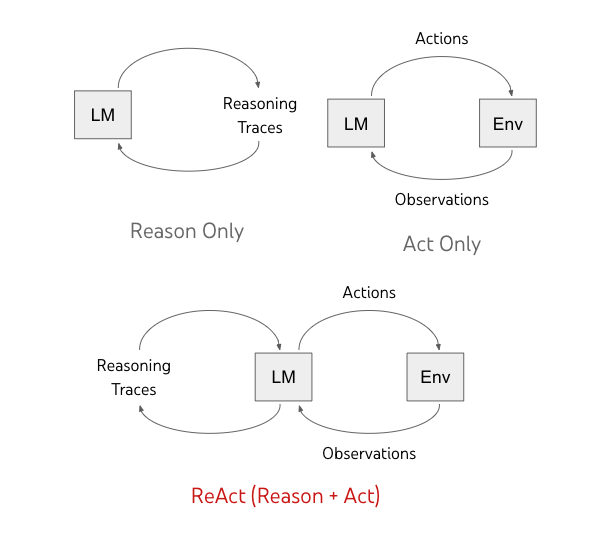

In [ ]:
url = "https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEiuuYg9Pduep9GkUfjloNVOiy3qjpPbT017GKlgGEGMaLNu_TCheEeJ7r8Qok6-0BK3KMfLvsN2vSgFQ8xOvnHM9CAb4Ix4I62bcN2oXFWfqAJzGAGbVqbeCyVktu3h9Dyf5ameRe54LEr32Emp0nG52iofpNOTXCxMY12K7fvmDZNPPmfJaT5zo1OBQA/s16000/Screen%20Shot%202022-11-08%20at%208.53.49%20AM.png"

img = Image.open(requests.get(url, stream=True).raw)

display(img)

In [ ]:
from llama_index.core.agent import ReActAgent
from llama_index.core.tools import QueryEngineTool, ToolMetadata
from llama_index.core import SummaryIndex

Define Summary Index and Vector Index over Same Data

In [ ]:
collection_name = "agent_collection"
chroma_agent_collection = vdb.create_collection(collection_name)
print(f"Collection '{collection_name}' created.")

vector_store = ChromaVectorStore(chroma_collection=chroma_agent_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

Collection 'agent_collection' created.


In [ ]:
vector_index = VectorStoreIndex(nodes, storage_context=storage_context)

In [ ]:
query_engine = vector_index.as_query_engine(
                                            similarity_top_k=3,
                                            verbose=True,
                                            llm=llm
                                           )

In [ ]:
query_engine_tools = [
    QueryEngineTool(
        query_engine=query_engine,
        metadata=ToolMetadata(
            name="t12_fin",
            description=(
                "Read the financial document and provide responses"
            ),
        ),
    ),
]

In [ ]:

context = "You are a Real Estate Property Financial Analyst. You will answer financial questions about the properties."

agent = ReActAgent.from_tools(
    query_engine_tools,
    llm=llm,
    verbose=True,
    context=context
)

In [ ]:
query

'What was the Net Operating Cash Flow in Jan 2023 at The Orion ?'

In [ ]:
response = agent.chat(query)
print(str(response))

Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: t12_fin
Action Input: {'input': 'Net Operating Cash Flow in Jan 2023 at The Orion'}
Retrieval entering be942200-8890-446d-97e3-758ba9517dac: TextNode
Retrieving from object TextNode with query Net Operating Cash Flow in Jan 2023 at The Orion
Observation: -18,191
Thought: I can answer without using any more tools. I'll use the user's language to answer
Answer: The Net Operating Cash Flow in January 2023 at The Orion was -18,191.
The Net Operating Cash Flow in January 2023 at The Orion was -18,191.


Let's try `gpt-3.5-turbo-instruct`.

In [ ]:
llm_instruct = OpenAI(model="gpt-3.5-turbo-instruct")

agent_instruct = ReActAgent.from_tools(
                                       query_engine_tools,
                                       llm=llm_instruct,
                                       verbose=True,
                                       context=context
                                      )

In [ ]:
response = agent.chat(query)
print(str(response))

Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: t12_fin
Action Input: {'input': 'Net Operating Cash Flow in Jan 2023 at The Orion'}
Retrieval entering be942200-8890-446d-97e3-758ba9517dac: TextNode
Retrieving from object TextNode with query Net Operating Cash Flow in Jan 2023 at The Orion
Observation: -18,191
Thought: I can answer without using any more tools. I'll use the user's language to answer
Answer: The Net Operating Cash Flow in January 2023 at The Orion was -18,191.
The Net Operating Cash Flow in January 2023 at The Orion was -18,191.


**Findings/Learnings/Observations:**

We get the same results with `ReAct` framework as with `Recursive + Re-reranker` retrieval. This, perhaps, suggests that we need to do some more work with `parsing` content.

### **Promising approach #3**

Multi-modal RAG (llama-index)

* https://developer.nvidia.com/blog/an-easy-introduction-to-multimodal-retrieval-augmented-generation/

* https://huggingface.co/docs/bitsandbytes/main/en/index

* https://huggingface.co/tasks/visual-question-answering

* https://cloud.google.com/vertex-ai/generative-ai/docs/image/visual-question-answering#-python

`bitsandbytes` enables accessible large language models via k-bit quantization for PyTorch. `bitsandbytes` provides three main features for dramatically reducing memory consumption for inference and training:

8-bit optimizers uses block-wise quantization to maintain 32-bit performance at a small fraction of the memory cost.

`LLM.Int()` or `8-bit quantization` enables large language model inference with only half the required memory and without any performance degradation. This method is based on vector-wise quantization to quantize most features to `8-bits` and separately treating outliers with `16-bit` matrix multiplication.
`QLoRA` or `4-bit` quantization enables large language model training with several memory-saving techniques that don’t compromise performance. This method quantizes a model to `4-bits` and inserts a small set of trainable low-rank adaptation (LoRA) weights to allow training.


In [ ]:
from transformers import FuyuProcessor, FuyuForCausalLM, BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
                                          load_in_4bit=True,
                                          bnb_4bit_quant_type="nf4",
                                          bnb_4bit_use_double_quant=True,
                                          bnb_4bit_compute_dtype=torch.bfloat16,
                                        )

In [ ]:
model_id = "adept/fuyu-8b"
processor = FuyuProcessor.from_pretrained(model_id)
model = FuyuForCausalLM.from_pretrained(model_id, quantization_config=quantization_config)

preprocessor_config.json:   0%|          | 0.00/192 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/848 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/6.13M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/58.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.93G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/8.88G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

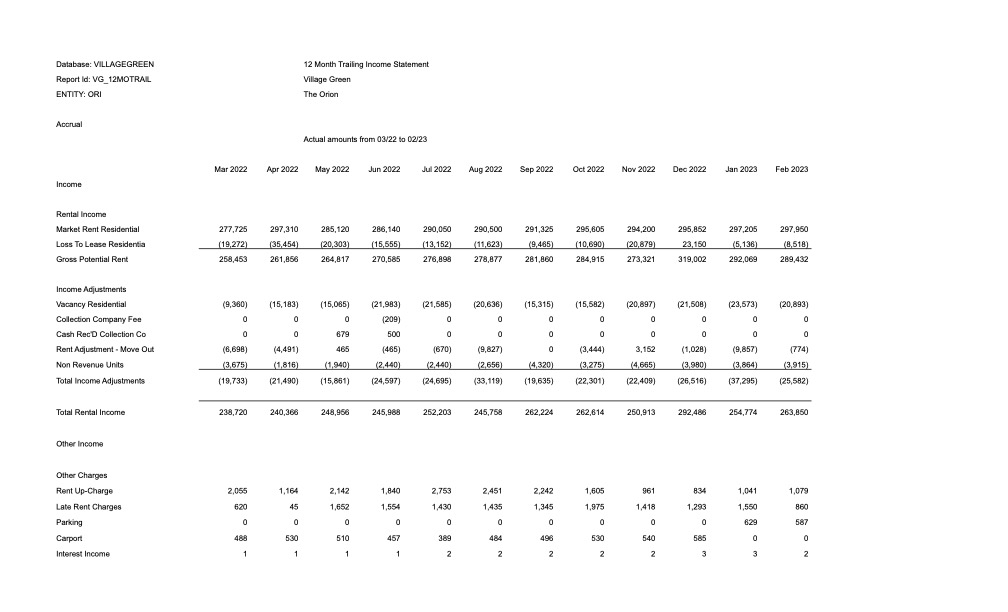

In [ ]:
jpg_folder_path = "/content/drive/My Drive/LLMs/Q&A/data/"

for f in os.listdir(jpg_folder_path):

  if f.endswith('.jpg'):
     img = Image.open(os.path.join(jpg_folder_path, f))

display(img)

In [ ]:
prompt = "What was the value of Non Revenue Units in Apr 2022?\n"
inputs = processor(images=img, text=prompt, return_tensors="pt").to(device="cuda", dtype=torch.float16)

In [ ]:
# autoregressively generate text
generation_output = model.generate(**inputs, max_new_tokens=16)
generation_text = processor.batch_decode(generation_output[:, -16:], skip_special_tokens=True)
print(generation_text)

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


['The Non Revenue Units in Apr 2022 are 1,164.']


Multi-Modal RAG using CLIP embedding model.

Running ollama locally: https://medium.com/@varsha.rainer/run-ollama-llama3-llm-on-google-colab-9b56b7254be9

https://github.com/ollama/ollama

In [ ]:
from llama_index.embeddings.clip import ClipEmbedding
from llama_index.core.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.multi_modal_llms.ollama import OllamaMultiModal
from llama_index.core.program import MultiModalLLMCompletionProgram
from transformers import AutoProcessor, LlavaForConditionalGeneration
from llama_index.core.output_parsers import PydanticOutputParser
import matplotlib.pyplot as plt

In [ ]:
mm_model = OllamaMultiModal(model="llava:13b")
mm_model

OllamaMultiModal(base_url='http://localhost:11434', model='llava:13b', temperature=0.75, context_window=3900, request_timeout=None, additional_kwargs={})

In [ ]:
img = SimpleDirectoryReader("/content/drive/MyDrive/LLMs/Q&A/data/images").load_data()
img

[ImageDocument(id_='281f8554-d6a6-48ce-8b9b-14445c9343e6', embedding=None, metadata={'file_path': '/content/drive/MyDrive/LLMs/Q&A/data/images/The_Orion_Alex.jpg', 'file_name': 'The_Orion_Alex.jpg', 'file_type': 'image/jpeg', 'file_size': 75547, 'creation_date': '2024-05-14', 'last_modified_date': '2024-05-12'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text='', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', image=None, image_path='/content/drive/MyDrive/LLMs/Q&A/data/images/The_Orion_Alex.jpg', image_url=None, image_mimetype=None, text_embedding=None)]

In [ ]:
prompt_template_str = """\
{query_str}

You are a financial agent that reads the documents and responds with exact figures / values.

Here are some examples:

The Gross Potential Rent in April 2022 was 261,856.
The Non Revenue Units in March 2022 was 3,675.

Return the answer as a Pydantic object. If you do not know the answer, don't make up.

"""

mm_program = MultiModalLLMCompletionProgram.from_defaults(
                                                            output_parser=PydanticOutputParser(Financials),
                                                            image_documents=img,
                                                            prompt_template_str=prompt_template_str,
                                                            multi_modal_llm=mm_model,
                                                            verbose=True,
                                                         )
mm_program

In [ ]:
query = "what were the Non Revenue Units in time period Feb 2023 at the Orion Village Green?"

In [ ]:
response = mm_program(query_str=query)
print(response)

> Raw output:  ```json
{
  "properties": {
    "Property": "Orion Village Green",
    "period": "Feb 2023",
    "Item": "Non Revenue Units",
    "Header": "Unit Count",
    "Sub_Header": null,
    "dollar_value": "541"
  }
}
```
Property=None period=None Item=None Header=None Sub_Header=None dollar_value=None


**Findings/Learnings/Observations:**

We tried a few different multi-modal (text+images) models for VQA based on the eval benchmarks[1]:

1.   https://huggingface.co/Salesforce/blip2-opt-2.7b
2.   https://huggingface.co/google/deplot

While not perfect, the best performing one seems to be `fuyu-8b`[2] from Adept.

[1] https://huggingface.co/adept/fuyu-8b - Evaluation

[2] https://www.adept.ai/blog/fuyu-8b


Further readings on `VLMs`:

1. Intro + Architecture: https://huggingface.co/blog/vlms
2. Leaderboard: https://huggingface.co/spaces/WildVision/vision-arena
3. https://github.com/langchain-ai/langchain/blob/master/cookbook/Multi_modal_RAG.ipynb
4. https://research.google/blog/react-synergizing-reasoning-and-acting-in-language-models/

On May 13th and 14th, OpenAI and Google released natively multi-modal models.

Let's try out them out.

In [ ]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal

In [ ]:
openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o",
    api_key=userdata.get('OPENAI_API_KEY'),
    max_new_tokens=300
)

In [ ]:
prompt_template_str = """\
{query_str}

You are a financial agent that reads the documents and responds with exact figures / values.

Here are some examples:

The Gross Potential Rent in April 2022 was 261,856.
The Non Revenue Units in time period March 2022 was 3,675.

Return the answer as a Pydantic object. If you do not know the answer, don't make up.

"""

openai_program = MultiModalLLMCompletionProgram.from_defaults(
                                                                  output_parser=PydanticOutputParser(Financials),
                                                                  image_documents=img,
                                                                  prompt_template_str=prompt_template_str,
                                                                  multi_modal_llm=openai_mm_llm,
                                                                  verbose=True,
                                                             )

In [ ]:
query = "What were the Non Revenue Units in time period Oct 2022 at the Orion Village Green?"

In [ ]:
openai_program(query_str=query)

> Raw output: ```json
{
  "Property": "Orion Village Green",
  "period": "Oct 2022",
  "Item": "Non Revenue Units",
  "Header": "Income Adjustments",
  "Sub_Header": null,
  "dollar_value": "-3,675"
}
```


Financials(Property='Orion Village Green', period='Oct 2022', Item='Non Revenue Units', Header='Income Adjustments', Sub_Header=None, dollar_value='-3,675')

Let's try to use the OpenAI API directly and encode the images.

In [ ]:
openai_client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

In [ ]:
def read_and_encode_images(directory):
    # List all files in the directory
    files = os.listdir(directory)

    # Filter out only JPEG files
    jpg_files = [file for file in files if file.endswith('.jpg')]

    encoded_images = []

    # Read and encode each JPEG image
    for jpg_file in jpg_files:
        file_path = os.path.join(directory, jpg_file)
        with open(file_path, 'rb') as f:
            image_data = f.read()
            encoded_image = base64.b64encode(image_data).decode('utf-8')
            encoded_images.append(encoded_image)

    return encoded_images

In [ ]:
jpg_folder_path = "/content/drive/My Drive/LLMs/Q&A/data/images"

base64_image = read_and_encode_images(jpg_folder_path)
base64_image

['/9j/4AAQSkZJRgABAQAASABIAAD/4QBARXhpZgAATU0AKgAAAAgAAYdpAAQAAAABAAAAGgAAAAAAAqACAAQAAAABAAAD8KADAAQAAAABAAACZAAAAAD/4gJASUNDX1BST0ZJTEUAAQEAAAIwQURCRQIQAABtbnRyUkdCIFhZWiAH0AAIAAsAEwAzADthY3NwQVBQTAAAAABub25lAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLUFEQkUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAApjcHJ0AAAA/AAAADJkZXNjAAABMAAAAGt3dHB0AAABnAAAABRia3B0AAABsAAAABRyVFJDAAABxAAAAA5nVFJDAAAB1AAAAA5iVFJDAAAB5AAAAA5yWFlaAAAB9AAAABRnWFlaAAACCAAAABRiWFlaAAACHAAAABR0ZXh0AAAAAENvcHlyaWdodCAyMDAwIEFkb2JlIFN5c3RlbXMgSW5jb3Jwb3JhdGVkAAAAZGVzYwAAAAAAAAARQWRvYmUgUkdCICgxOTk4KQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAWFlaIAAAAAAAAPNRAAEAAAABFsxYWVogAAAAAAAAAAAAAAAAAAAAAGN1cnYAAAAAAAAAAQIzAABjdXJ2AAAAAAAAAAECMwAAY3VydgAAAAAAAAABAjMAAFhZWiAAAAAAAACcGAAAT6UAAAT8WFlaIAAAAAAAADSNAACgLAAAD5VYWVogAAAAAAAAJjEAABAvAAC+nP/AABEIAmQD8AMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQ

dict[__main__.Financials]

In [ ]:
def get_chat_completions(messages, model):

    response = openai_client.chat.completions.create(

                                                      model = model,
                                                      temperature = 0,
                                                      messages = messages,
                                                      max_tokens = 300,
                                                      tools=[Financials.openai_schema],
                                                      function_call={"name": Financials.openai_schema["name"]},

                                                    )
    return response.choices[0].message.content

def append_message(content, query):

    content.append({"type": "text", "text": query})

    messages = [
        {
            "role": "user",
            "content": content
        }

    ]

    return messages

In [ ]:
query = "What were the Non Revenue Units in time period Jan 2023 at the Orion Village Green?"

In [ ]:
content = [

            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
              }
            }
          ]

messages = append_message(content, query)
messages

[{'role': 'user',
  'content': [{'type': 'image_url',
    'image_url': {'url': "data:image/jpeg;base64,['/9j/4AAQSkZJRgABAQAASABIAAD/4QBARXhpZgAATU0AKgAAAAgAAYdpAAQAAAABAAAAGgAAAAAAAqACAAQAAAABAAAD8KADAAQAAAABAAACZAAAAAD/4gJASUNDX1BST0ZJTEUAAQEAAAIwQURCRQIQAABtbnRyUkdCIFhZWiAH0AAIAAsAEwAzADthY3NwQVBQTAAAAABub25lAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLUFEQkUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAApjcHJ0AAAA/AAAADJkZXNjAAABMAAAAGt3dHB0AAABnAAAABRia3B0AAABsAAAABRyVFJDAAABxAAAAA5nVFJDAAAB1AAAAA5iVFJDAAAB5AAAAA5yWFlaAAAB9AAAABRnWFlaAAACCAAAABRiWFlaAAACHAAAABR0ZXh0AAAAAENvcHlyaWdodCAyMDAwIEFkb2JlIFN5c3RlbXMgSW5jb3Jwb3JhdGVkAAAAZGVzYwAAAAAAAAARQWRvYmUgUkdCICgxOTk4KQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAWFlaIAAAAAAAAPNRAAEAAAABFsxYWVogAAAAAAAAAAAAAAAAAAAAAGN1cnYAAAAAAAAAAQIzAABjdXJ2AAAAAAAAAAECMwAAY3VydgAAAAAAAAABAjMAAFhZWiAAAAAAAACcGAAAT6UAAAT8WFlaIAAAAAAAADSNAACgLAAAD5VYWVogAAAAAAAAJjEAABAvAAC+nP/AABEIAmQ

In [ ]:
%%time
model = "gpt-4o"
print(get_chat_completions(messages, model))

TypeError: Completions.create() got an unexpected keyword argument 'response_model'

`gpt-4o` is by far the most accurate.

#### Llamaindex on VertexAI

In [ ]:
# Initialize Vertex AI API once per session

credentials = service_account.Credentials.from_service_account_file('stroom-vertexai-37730f77939e.json')
vertexai.init(project=project_id, location="us-central1", credentials=credentials)

In [ ]:
import base64
import vertexai
from vertexai.generative_models import GenerativeModel, Part, FinishReason
import vertexai.preview.generative_models as generative_models

def generate():
  vertexai.init(project="stroom-vertexai", location="us-central1")
  model = GenerativeModel(
    "gemini-1.5-flash-preview-0514",
  )
  responses = model.generate_content(
      [],
      generation_config=generation_config,
      safety_settings=safety_settings,
      stream=True,
  )

  for response in responses:
    print(response.text, end="")


generation_config = {
    "max_output_tokens": 2017,
    "top_p": 0.95,
}

safety_settings = {
    generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
}

generate()



In [ ]:
import torch
import torch.nn as nn

# Example true labels (batch of size 2, 3 classes)
true_labels = torch.tensor([2, 0])  # Indices of the true classes
print('ground truth indices', true_labels)

# Example predicted probabilities (logits from the model)
logits = torch.tensor([[1.0, 2.0, 3.0], [1.0, 3.0, 2.0]])

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Compute the loss
loss = criterion(logits, true_labels)

print('Cross-Entropy Loss:', loss.item())

ground truth indices tensor([2, 0])
Cross-Entropy Loss: 1.4076060056686401


In [ ]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 2.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer

# Sample data
data = {'sku': ['SKU123', 'SKU456', 'SKU789'],
        'description': ['This is a red shirt', 'This is a blue jeans', 'This is a black hat']}

# Create DataFrame
df = pd.DataFrame(data)

# Load pre-trained sentence embedding model
model = SentenceTransformer('all-mpnet-base-v2')

# Create embeddings for descriptions
df['embedding'] = model.encode(df['description'], convert_to_numpy=True)

# Calculate cosine similarity between embeddings
similarity_matrix = np.empty((len(df), len(df)))  # Initialize empty matrix

for i, row in df.iterrows():
  embedding = row['embedding']

  print(i, embedding)

  #similarity_matrix[i] = np.dot(embedding, df['embedding'].values)

#similarity_matrix = pd.DataFrame(similarity_matrix, index=df['sku'].tolist(), columns=df['sku'].tolist())

# Print DataFrame with embeddings and similarity matrix
#print(df)
#print(similarity_matrix)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ValueError: Expected a 1D array, got an array with shape (3, 768)

#### Evaluation

**Task specific evaluation metric**

For queries where we are retrieving exact values from the financial statement, example, `what was the total income in 2023 for Property A`, we measure the exact match with ground-truth. The evaluation metric for these types of queries: `proportion of correct predictions / total predictions`.

**BLEU (Bilingual Evaluation Understudy)** is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another. Quality is considered to be the correspondence between a machine’s output and that of a human: “the closer a machine translation is to a professional human translation, the better it is” – this is the central idea behind BLEU. BLEU was one of the first metrics to claim a high correlation with human judgements of quality, and remains one of the most popular automated and inexpensive metrics.

Scores are calculated for individual translated segments—generally sentences—by comparing them with a set of good quality reference translations. Those scores are then averaged over the whole corpus to reach an estimate of the translation’s overall quality. Neither intelligibility nor grammatical correctness are not taken into account.

```
N-gram Precision Calculation:

Count the number of n-grams in the candidate translation that appear in any of the reference translations.
Divide by the total number of n-grams in the candidate translation.
Do this for different values of n (typically 1 to 4).


Combine N-gram Precisions:

Take the geometric mean of the n-gram precisions.
This gives more weight to longer n-gram matches.
```

Output values:

```
bleu (float): bleu score
precisions (list of floats): geometric mean of n-gram precisions,
brevity_penalty (float): brevity penalty,
length_ratio (float): ratio of lengths,
translation_length (int): translation_length,
reference_length (int): reference_length
```

BLEU’s output is always a number between 0 and 1. This value indicates how similar the candidate text is to the reference texts, with values closer to 1 representing more similar texts. Few human translations will attain a score of 1, since this would indicate that the candidate is identical to one of the reference translations.

**ROGUE**, or Recall-Oriented Understudy for Gisting Evaluation, is a set of metrics and a software package used for evaluating automatic summarization and machine translation software in natural language processing. The metrics compare an automatically produced summary or translation against a reference or a set of references (human-produced) summary or translation.

Note that ROUGE is case insensitive, meaning that upper case letters are treated the same way as lower case letters.

```
Count_match(gram_n) is the maximum number of n-grams co-occurring in the candidate summary and the reference summary
```


**BLUE and ROGUE**

- Purpose and Use Case:

BLEU: Primarily used for machine translation. It measures how closely a generated text matches a reference text based on the precision of n-grams (short sequences of words).

ROUGE: Commonly used for text summarization. It measures the recall of n-grams, longest common subsequence (LCS), and word sequences between the generated text and reference text.

- Precision vs. Recall:

BLEU: Focuses on precision. It calculates the proportion of n-grams in the generated text that match n-grams in the reference text, without penalizing for missing n-grams that are present in the reference text.

ROUGE: Focuses on recall. It measures how many n-grams, sequences, or subsequences in the reference text are also present in the generated text, indicating how much of the reference content is covered.


In [ ]:
from datasets import load_metric

# Load the metrics
bleu_metric = load_metric("bleu")
rouge_metric = load_metric("rouge")

In [ ]:
# Prepare Ground Truth
ground_truth = [
    {"question": "What was the net income for Q4 2023?", "answer": "The net income for Q4 2023 was $5 million."},
    {"question": "What are the company's main sources of revenue?", "answer": "The main sources of revenue are product sales and service contracts."}
    # Add more question-answer pairs...
]


# Save ground truth to a JSON file
with open("eval_dataset.json", "w") as f:
    json.dump(ground_truth, f, indent=4)

In [ ]:
def evaluate_rag_model(model, tokenizer, eval_data):
    generated_answers = []
    reference_answers = []

    for qa in eval_data:
        question = qa["question"]
        expected_answer = qa["answer"]

        # Tokenize the input question
        inputs = tokenizer(question, return_tensors="pt")

        # Generate the answer
        generated_ids = model.generate(input_ids=inputs["input_ids"])
        generated_answer = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

        generated_answers.append(generated_answer)
        reference_answers.append(expected_answer)

        print(f"Question: {question}")
        print(f"Generated Answer: {generated_answer}")
        print(f"Expected Answer: {expected_answer}")
        print()

    # Compute BLEU score
    bleu_results = bleu_metric.compute(predictions=[gen.split() for gen in generated_answers],
                                       references=[[ref.split()] for ref in reference_answers])
    bleu_score = bleu_results["bleu"]

    # Compute ROUGE score
    rouge_results = rouge_metric.compute(predictions=generated_answers, references=reference_answers)
    rouge_score = rouge_results["rougeL"].mid.fmeasure

    return bleu_score, rouge_score, bertscore_f1

In [ ]:
# Evaluate the model
bleu_score, rouge_score = evaluate_rag_model(model, tokenizer, eval_dataset)
print(f"BLEU Score: {bleu_score:.4f}")
print(f"ROUGE Score: {rouge_score:.4f}")

**Embedchain example**

In [ ]:
from embedchain import App

In [ ]:
app = App.from_config(config={
                                  "llm": {
                                      "provider": "huggingface",
                                      "config": {
                                          "model": "google/flan-t5-xxl",
                                          "temperature": 0.5,
                                          "max_tokens": 1000,
                                          "top_p": 0.8,
                                          "stream": False
                                      }
                                  },
                                  "embedder": {
                                      "provider": "huggingface",
                                      "config": {
                                          "model": "sentence-transformers/all-mpnet-base-v2"
                                      }
                                  }
                             })

app

AttributeError: type object 'App' has no attribute 'from_config'


*   https://docs.aws.amazon.com/lambda/latest/dg/with-s3-example.html

Feedback from Nico:

1. Use the exact same embedding function.
2. PDF Format - detect the tables. Print - fit to width.
3. Pre-process the pdf page and use markdown format to parse the table. Clean table. https://camelot-py.readthedocs.io/en/master